In [1]:
%pylab inline
import matplotlib as mpl

matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.table as astTable

import os
import json
import haloSim
import cosmology
import numpy as np
from pixel3D import cartesianGrid3D
from configparser import ConfigParser
from sparseBase import massmapSparsityTask

#important constant
C_LIGHT=2.99792458e8        # m/s
GNEWTON=6.67428e-11         # m^3/kg/s^2
KG_PER_SUN=1.98892e30       # kg/M_solar
M_PER_PARSEC=3.08568025e16  # m/pc
def four_pi_G_over_c_squared():
    # = 1.5*H0^2/roh_0/c^2
    # We want it return 4piG/c^2 in unit of Mpc/M_solar
    # in unit of m/kg
    fourpiGoverc2 = 4.0*np.pi*GNEWTON/(C_LIGHT**2)
    # in unit of pc/M_solar
    fourpiGoverc2 *= KG_PER_SUN/M_PER_PARSEC
    # in unit of Mpc/M_solar
    fourpiGoverc2 /= 1.e6
    return fourpiGoverc2

Populating the interactive namespace from numpy and matplotlib


### Test for spin-0 $2$-D $\Sigma$ field

## Lensing Kernel

In [2]:
ver='nl10'
configName  =   'wrkDir/sim/HSC-like-sim/config-%s.ini' %ver
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)

In [3]:
# Load data for photo-z PDF
tn='9347.fits'
cfn='datDir/S16AStandardCalibrated/tract/%s' %tn
cdata=pyfits.getdata(cfn)
poz_best=cdata['mlz_photoz_best']
pfn='datDir/S16AStandardCalibrated/tract/%s_pofz.fits' %tn.split('.')[0]
poz_data=pyfits.getdata(pfn)['PDF']
bfn='datDir/S16AStandardV2/field/pz_pdf_bins_mlz.fits'
poz_bins=pyfits.getdata(bfn)['BINS']
lensKernel=gridInfo.lensing_kernel()
lensKernel2= gridInfo.lensing_kernel(poz_grids=poz_bins,poz_data=poz_data,poz_best=poz_best)

0.007363250616960725 0.007361259665069776
0.022025656835650387 0.02177061636393745
0.019081270136403226 0.01724855429723527
The photo-z uncertainty distort the lensing Efficiency towards the low redshift direction.


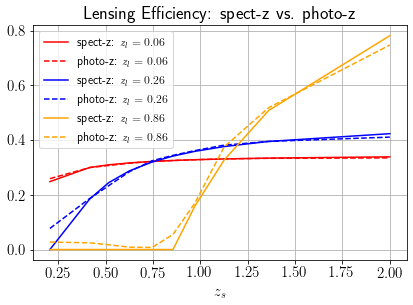

In [5]:
for i,color in zip([0,2,8],['red','blue','orange']):
    toPlt=lensKernel[:,i]
    norm=np.sqrt(np.sum(lensKernel[:,i]**2.))
    norm2=np.sqrt(np.sum(lensKernel2[:,i]**2.))
    plt.plot(gridInfo.zcgrid,lensKernel[:,i]/norm,'-',label=r'spect-z: $z_l=%.2f$' %gridInfo.zlcgrid[i],color=color)
    plt.plot(gridInfo.zcgrid,lensKernel2[:,i]/norm2,'--',label=r'photo-z: $z_l=%.2f$' %gridInfo.zlcgrid[i],color=color)
    print(norm,norm2)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.xlabel(r'$z_s$')
plt.title('Lensing Efficiency: spect-z vs. photo-z')
print('The photo-z uncertainty distort the lensing Efficiency towards the low redshift direction.')
pyfits.writeto('./wrkDir/sim/HSC-like-sim/pixelize-equalNum-%s/lensing_kernel.fits' %ver,lensKernel2,overwrite=True)

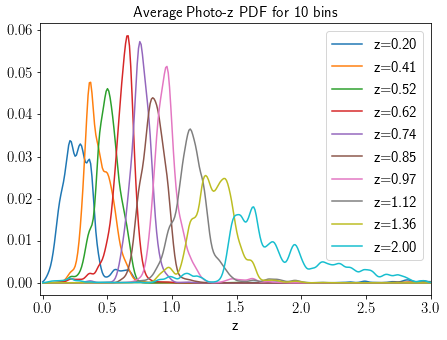

In [13]:
fig=plt.figure(figsize=(7,5))
for i in range(0,gridInfo.nz,1):
    plt.plot(poz_bins,gridInfo.poz_ave[i],label='z=%.2f' %(gridInfo.zcgrid[i]))
plt.legend()
plt.xlim(-0.02,3)
plt.title('Average Photo-z PDF for 10 bins',fontsize=15)
plt.xlabel('z',fontsize=15)
pyfits.writeto('./wrkDir/sim/HSC-like-sim/pixelize-equalNum-%s/poz_ave.fits' %ver,gridInfo.poz_ave,overwrite=True)

# Test the lensing kernel with simulation

In [18]:
# Pixelize simulation again
iz  =  4
im  =  4

# Load 3D position infomation
infname='wrkDir/sim/HSC-like-sim/sims/stampSim-HSC_like-TJ03-%d,%d-202004021856.fits' %(iz,im)
data=astTable.Table.read(infname)
ng=len(data)//100
dataU=data[:ng]

# Load Halo infomation
haloCat=astTable.Table.read('wrkDir/sim/HSC-like-sim/sims//haloCat.csv')
msk=(haloCat['im']==im)&(haloCat['iz']==iz)
mass=10**(haloCat[msk]['log10_M200'])
zh=haloCat[msk]['zh']
conc=haloCat[msk]['conc']
halo=haloSim.nfw_lensTJ03(mass=mass,conc=conc,redshift=zh,ra=0.,dec=0.)
    
SigmaArray=halo.Sigma(dataU['raR']*3600.,dataU['decR']*3600.)
lensKer= halo.lensKernel(dataU['ztrue'])
#kappa=SigmaArray*lensKer

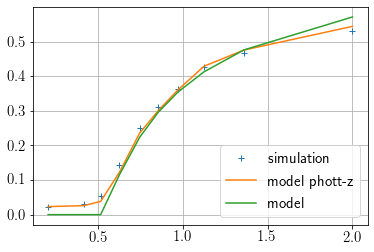

In [26]:
kerzshow=np.zeros(gridInfo.nz)
for i in range(gridInfo.nz):
    mask=(dataU['zbest']>gridInfo.zbound[i])&(dataU['zbest']<=gridInfo.zbound[i+1])
    kerzshow[i]=np.average(halo.M*lensKer[mask])
norm1=np.sqrt(np.sum(kerzshow**2.))
norm2=np.sqrt(np.sum(lensKernel2[:,10]**2.))
norm3=np.sqrt(np.sum(lensKernel[:,10]**2.))
plt.plot(gridInfo.zcgrid,kerzshow/norm1,'+',label='simulation')
plt.plot(gridInfo.zcgrid,lensKernel2[:,10]/norm2,label='model phott-z')
plt.plot(gridInfo.zcgrid,lensKernel[:,10]/norm3,label='model')
plt.grid()
plt.legend(fontsize=15,loc='lower right')